In [2]:
import pandas as pd
import numpy as np
import os
from pathlib import Path 
import missingno as msno
from tabulate import tabulate
from statistics import median, mean, quantiles
import pprint

## Import et Exploration

### Lire les 9 fichiers csv

In [3]:
path = Path(os.getcwd()) 
p_parent = path.parent
p_customer = str(p_parent) + '\data\olist_customers_dataset.csv'
p_geo = str(p_parent) + '\data\olist_geolocation_dataset.csv'
p_order_item = str(p_parent) + '\data\olist_order_items_dataset.csv'
p_order_payment = str(p_parent) + '\data\olist_order_payments_dataset.csv'
p_order_review = str(p_parent) + '\data\olist_order_reviews_dataset.csv'
p_orders = str(p_parent) + '\data\olist_orders_dataset.csv'
p_products = str(p_parent) + '\data\olist_products_dataset.csv'
p_sellers = str(p_parent) + '\data\olist_sellers_dataset.csv'
p_category = str(p_parent) + '\data\product_category_name_translation.csv'

In [4]:
customer = pd.read_csv(p_customer)
geo = pd.read_csv(p_geo)
order_item = pd.read_csv(p_order_item)
order_payment = pd.read_csv(p_order_payment)
order_review = pd.read_csv(p_order_review)
orders = pd.read_csv(p_orders)
products = pd.read_csv(p_products)
sellers = pd.read_csv(p_sellers)
category = pd.read_csv(p_category)

## Fusionner dans un dataframe

### Approche orienté sur la table Order

In [6]:
df = order_item.merge(orders, on="order_id", how ='left')
df = df.merge(customer, on= "customer_id", how = 'left')
df = df.merge(products, on = "product_id", how = 'left')
df = df.merge(order_payment, on ='order_id', how ='left')
df = df.merge(order_review, on ="order_id", how="left")
df = df.merge(sellers, on ='seller_id', how ="left")

In [ ]:
#geo_seller = geo.rename(columns={"geolocation_zip_code_prefix":"seller_zip_code_prefix",
#                                 "geolocation_lat":"seller_lat",
#                                 "geolocation_lng":'seller_lng',
#                                 "geolocation_city": "seller_city",
#                                 "geolocation_state":"seller_state"})
#geo_customer = geo.rename(columns={"geolocation_zip_code_prefix":"customer_zip_code_prefix",
#                                   "geolocation_lat":"customer_lat",
#                                   "geolocation_lng":'customer_lng',
#                                   "geolocation_city": "customer_city",
#                                   "geolocation_state":"customer_state"})
#df = df.merge(geo_seller, on ="seller_zip_code_prefix", how ='left')
#df = df.merge(geo_customer, on ="customer_zip_code_prefix", how ='left')

#les données géographiques sont trop volumineuse pour être integré dans le dataframe unique

In [7]:
df= df.drop_duplicates()
output = []
for col in df.columns:

    nonNull  = len(df) - np.sum(pd.isna(df[col]))
    nonNullprop = (nonNull / len(df[col]))*100
    unique = df[col].nunique()
    colType = str(df[col].dtype)
    output.append([col, colType, nonNull, round(nonNullprop, 1) , unique])
        

df_stats = pd.DataFrame(output)
df_stats.columns = ['nom colonne','dtype', 'valeur non null',"% de non null", 'nb_unique']

print(tabulate(df_stats, headers='keys', tablefmt='psql'))

+----+-------------------------------+---------+-------------------+-----------------+-------------+
|    | nom colonne                   | dtype   |   valeur non null |   % de non null |   nb_unique |
|----+-------------------------------+---------+-------------------+-----------------+-------------|
|  0 | order_id                      | object  |            118310 |           100   |       98666 |
|  1 | order_item_id                 | int64   |            118310 |           100   |          21 |
|  2 | product_id                    | object  |            118310 |           100   |       32951 |
|  3 | seller_id                     | object  |            118310 |           100   |        3095 |
|  4 | shipping_limit_date           | object  |            118310 |           100   |       93318 |
|  5 | price                         | float64 |            118310 |           100   |        5968 |
|  6 | freight_value                 | float64 |            118310 |           100   |     

On peut voir que des traitements sont nécessaire sur les données :
- les dates ne sont pas au bon format

<AxesSubplot:>

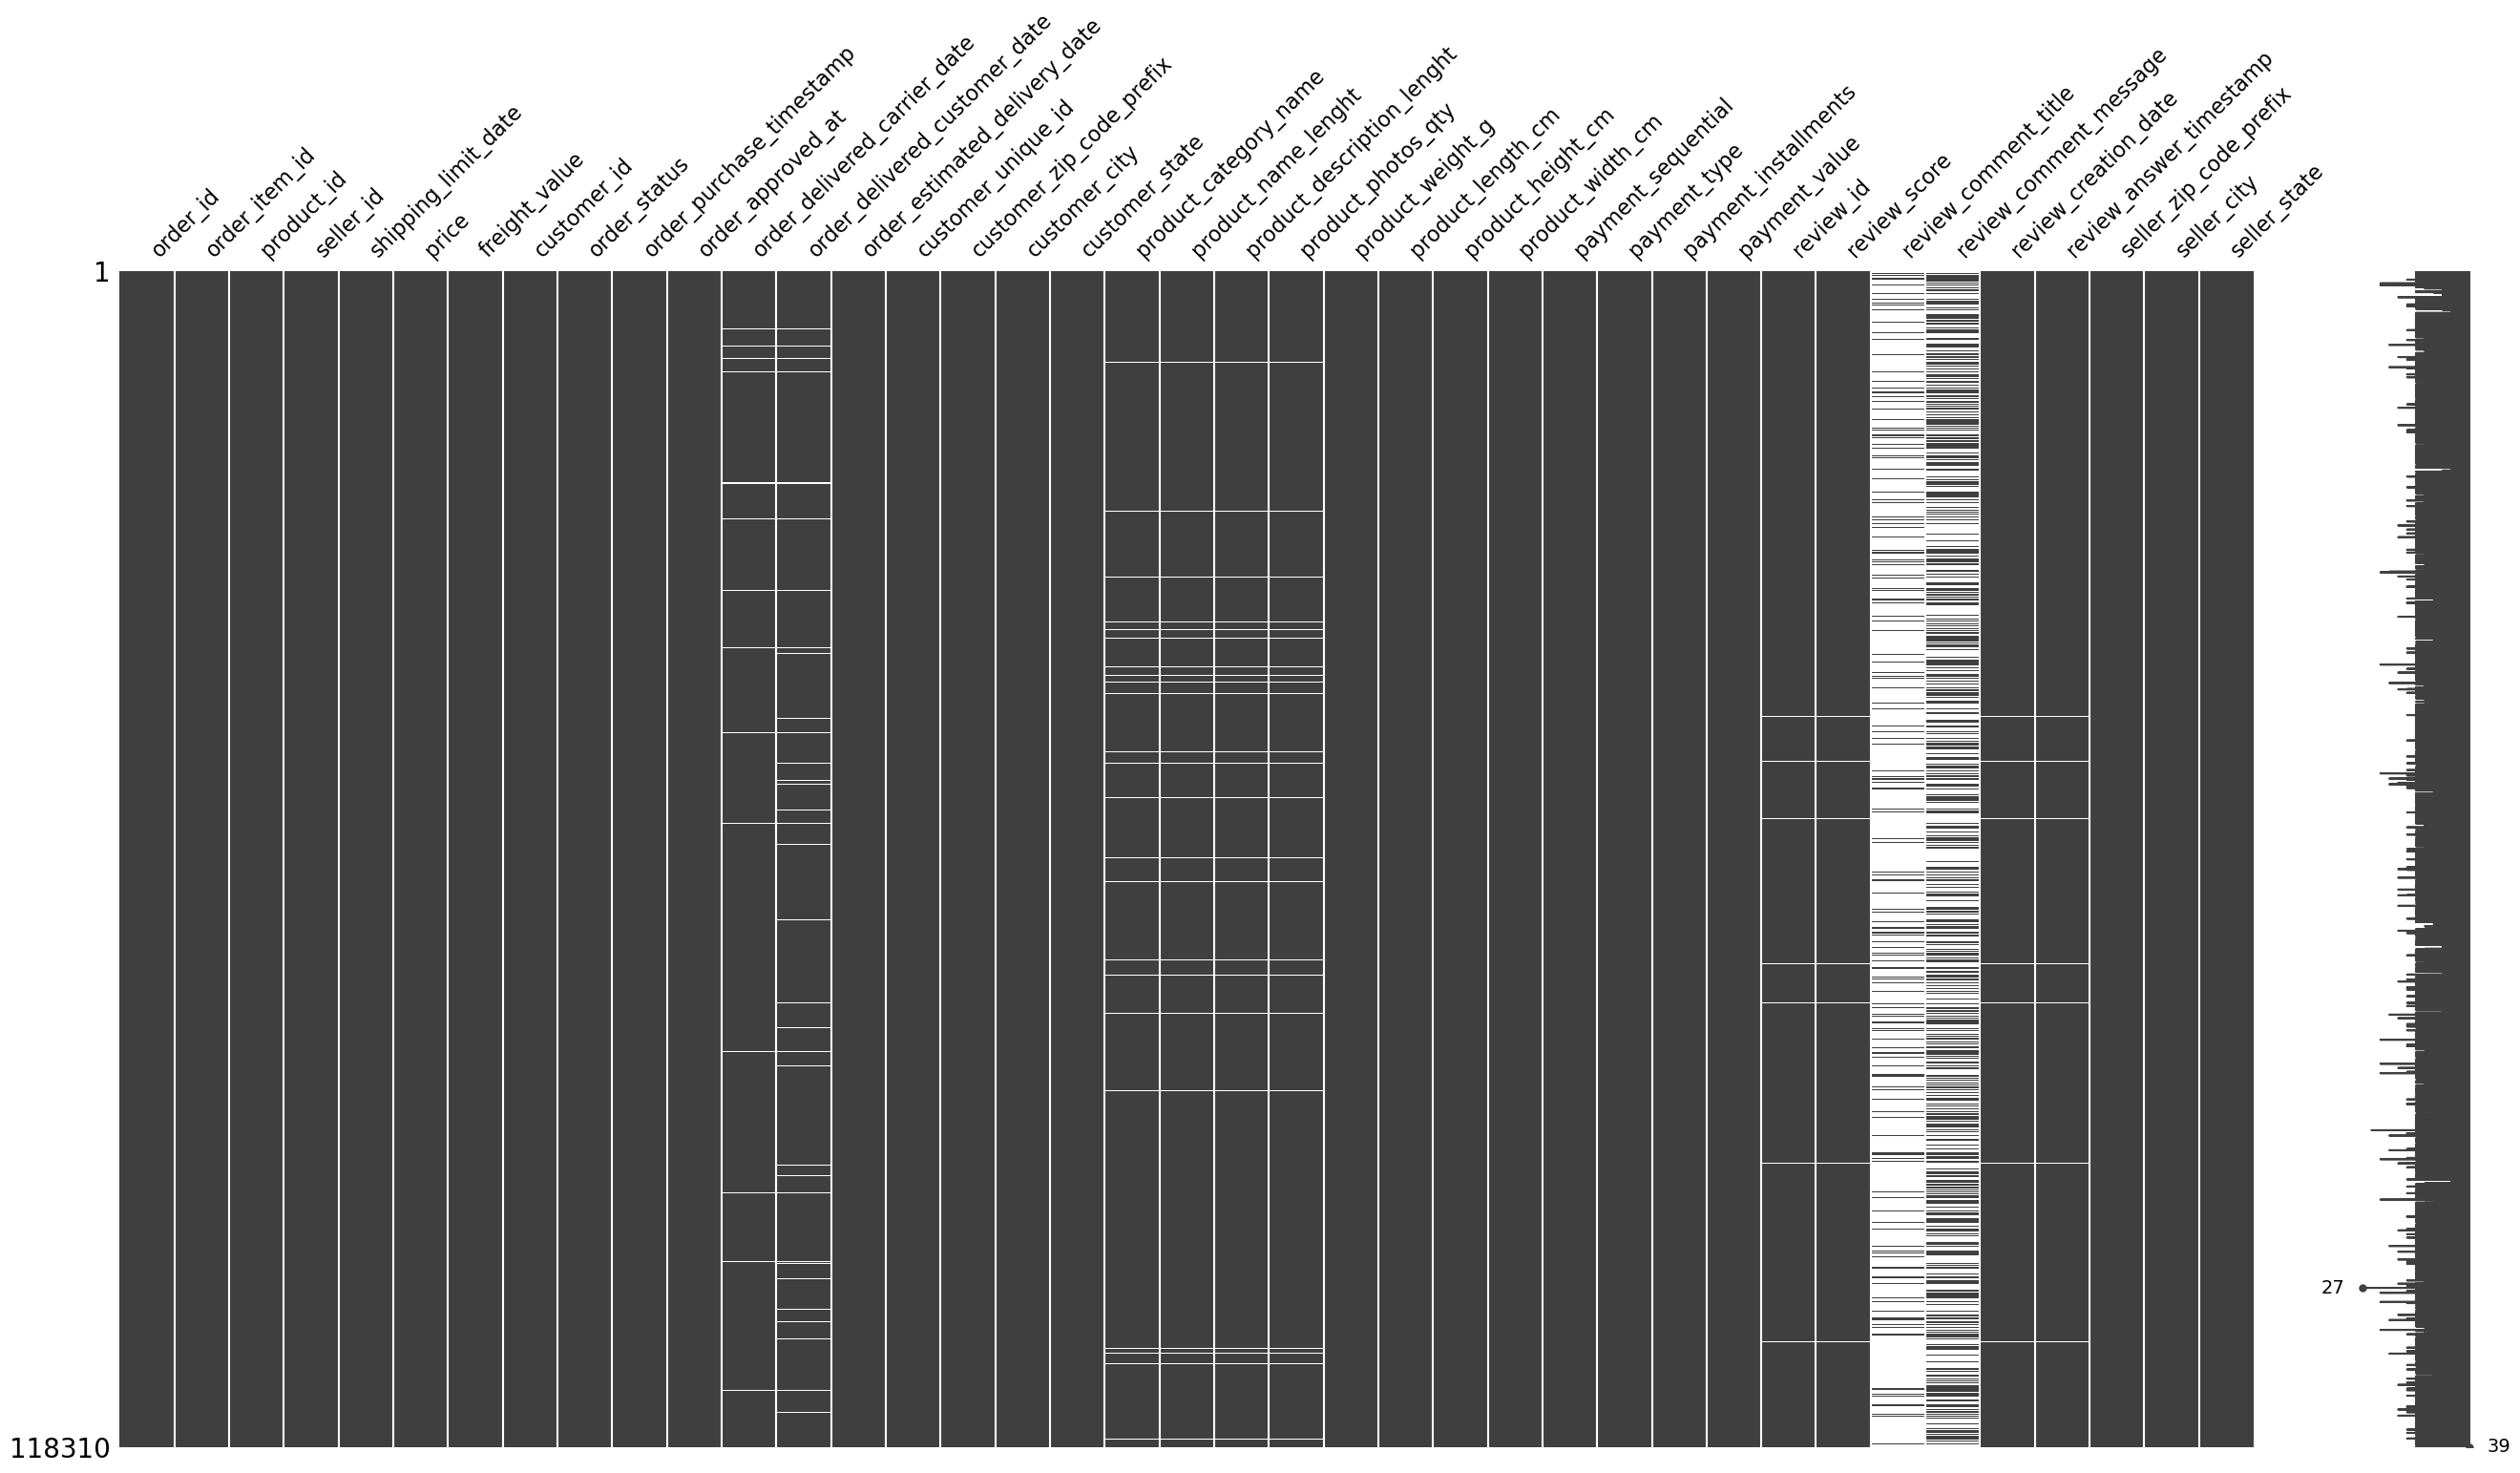

In [8]:
msno.matrix(df, figsize=(32,16))

On peut voir que les champs sont relativement bien remplis a l'exeption de "review_comment_title" et "review_comment_message"

In [9]:
df_num= df.select_dtypes(include=["int64", "float64"])
df_num.drop(columns=['customer_zip_code_prefix', 'seller_zip_code_prefix', "order_item_id"], inplace = True)
output = []
for col in df_num.columns:

    nonNull  = len(df) - np.sum(pd.isna(df[col]))
    nonNullprop = (nonNull / len(df[col]))*100
    unique = df[col].nunique()
    colType = str(df[col].dtype)
    min = np.min(df[col])
    max = np.max(df[col])
    moyenne = round(np.nanmean(df[col]),2)
    quantile25 = np.nanquantile(df[col],0.25)
    quantile5 = np.nanquantile(df[col],0.5)
    quantile75 = np.nanquantile(df[col],0.5)
    std = round(np.nanstd(df[col]),2)
    var = round(np.nanvar(df[col]),2)
    output.append([col, min, max, quantile25, quantile5, quantile75, std, var]) 
        
df_stats = pd.DataFrame(output)
df_stats.columns = ['nom colonne', "min", "max", 'quantile.25', 'median', 'quantile.75', 'std', 'var']


pp = pprint.PrettyPrinter(indent=4)
#print(tabulate(df_stats, headers='keys', tablefmt='psql'))
pp.pprint(df_stats)

                   nom colonne   min       max  quantile.25  median  \
0                        price  0.85   6735.00        39.90   74.90   
1                freight_value  0.00    409.68        13.08   16.28   
2          product_name_lenght  5.00     76.00        42.00   52.00   
3   product_description_lenght  4.00   3992.00       346.00  600.00   
4           product_photos_qty  1.00     20.00         1.00    1.00   
5             product_weight_g  0.00  40425.00       300.00  700.00   
6            product_length_cm  7.00    105.00        18.00   25.00   
7            product_height_cm  2.00    105.00         8.00   13.00   
8             product_width_cm  6.00    118.00        15.00   20.00   
9           payment_sequential  1.00     29.00         1.00    1.00   
10        payment_installments  0.00     24.00         1.00    2.00   
11               payment_value  0.00  13664.08        60.85  108.20   
12                review_score  1.00      5.00         4.00    5.00   

    q

## Pré-traitement

In [123]:
# transformation des colonnes date en format date

col_date = ['order_purchase_timestamp', 
            'order_approved_at', 
            'order_delivered_carrier_date', 
            'order_estimated_delivery_date']
df[col_date].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119143 entries, 0 to 119142
Data columns (total 4 columns):
 #   Column                         Non-Null Count   Dtype 
---  ------                         --------------   ----- 
 0   order_purchase_timestamp       119143 non-null  object
 1   order_approved_at              118966 non-null  object
 2   order_delivered_carrier_date   117057 non-null  object
 3   order_estimated_delivery_date  119143 non-null  object
dtypes: object(4)
memory usage: 4.5+ MB


In [124]:
df[col_date] = df[col_date].apply(pd.to_datetime)
df[col_date].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119143 entries, 0 to 119142
Data columns (total 4 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_purchase_timestamp       119143 non-null  datetime64[ns]
 1   order_approved_at              118966 non-null  datetime64[ns]
 2   order_delivered_carrier_date   117057 non-null  datetime64[ns]
 3   order_estimated_delivery_date  119143 non-null  datetime64[ns]
dtypes: datetime64[ns](4)
memory usage: 4.5 MB
